# Shooting Method for Boundary Value Problems

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import time


## Boundary Value Problem

Consider the following second-order differential equation:

$y'' = - (y')^2 + 12 y + 9x^4 + -2x^2 - 2x +3$

subject to the boundary conditions:
* $y(0) = 0$
* $y(1) = 3$

### Solution
The exact solution to the problem is given by \\
$y = x^3 + x^2 + x$


In [78]:
# Initial Conditions
x0=0
x1=1
y0=0
y1=3
h = 0.01

## We will change BVP to two IVPs as follows
* $y' = z$  
* $y'' = - (z)^2 + 12 y + 9x^4 + -2x^2 - 2x +3$

Then any explicit IVP solver can be used to easily get values of $y_{i+1} , z_{i+1} \& y''_{i+1}$ using previous values of $y , z, y'' $

In [79]:
def Y_xx(x, y, z):
  return -1*(z*z) + 12*y + 9*x**4 - 2*x*x - 2*x + 3


def y_upd(y, z, i, h):
  time.sleep(0.0005)  #adding little delay to observe difference in time while parallel computing
  return y[i] + h/24 * (55*z[i] - 59*z[i-1] + 37*z[i-2] - 9*z[i-3])

def z_upd(x, y, z, i, h):
  time.sleep(0.0005)  #adding little delay to observe difference in time while parallel computing
  return z[i] + h/24 * (55*Y_xx(x[i], y[i], z[i]) - 59*Y_xx(x[i-1], y[i-1], z[i-1]) + 37*Y_xx(x[i-2], y[i-2], z[i-2]) -9*Y_xx(x[i-3], y[i-3], z[i-3]))


## Solving BVP using shooting method

In [80]:

def solve_ivps(Z_x, y0, z0, h):
  N = int(1/h) + 1
  x = np.linspace(0, 1, N)
  y = [0]*N
  z = [0]*N

  y[0] = y0
  z[0] = z0
  y[1] = y[0] + h*z[0]
  z[1] = z[0] + h*Z_x(x[0], y[0], z[0])
  y[2] = y[1] + h*z[1]
  z[2] = z[1] + h*Z_x(x[1], y[1], z[1])
  y[3] = y[2] + h*z[2]
  z[3] = z[2] + h*Z_x(x[2], y[2], z[2])


  for i in range(4, N):
    y[i] = y_upd(y, z, i-1, h)
    z[i] = z_upd(x, y, z, i-1, h)

  return y



def solve_bvp(h, tolerance):
  l = 0
  r = 50

  y_end = solve_ivps(Y_xx, y0, l, h)[-1]

  while(abs(y_end-y1)>tolerance and l<=r):
      mid = (l+r)/2

      y_end = solve_ivps(Y_xx, y0, mid, h)[-1]
      if(y_end<y1):
          l = mid + 0.01
      else:
          r = mid - 0.01

  if(abs(y_end-y1)>tolerance):
      print("Solution not found")

  return solve_ivps(Y_xx, y0, mid, h)


In [44]:
st = time.time()
y_approx = solve_bvp(h, 0.05)
end = time.time()
print(f"Execution time without parallel computing: {(end-st)*1000} milliseconds ")


Execution time without parallel computing: 1177.633285522461 milliseconds 


## Solving BVP using shooting method with taking advantage of parallel computing

In [45]:
def solve_ivps_parallel(Z_x, y0, z0, h):
  N = int(1/h) + 1
  x = np.linspace(0, 1, N)
  y = [0]*N
  z = [0]*N

  y[0] = y0
  z[0] = z0
  y[1] = y[0] + h*z[0]
  z[1] = z[0] + h*Z_x(x[0], y[0], z[0])
  y[2] = y[1] + h*z[1]
  z[2] = z[1] + h*Z_x(x[1], y[1], z[1])
  y[3] = y[2] + h*z[2]
  z[3] = z[2] + h*Z_x(x[2], y[2], z[2])


  for i in range(4, N):
      with ThreadPoolExecutor() as executor:
          future1 = executor.submit(y_upd, y, z, i-1, h)
          future2 = executor.submit(z_upd, x, y, z, i-1, h)

          y[i] = future1.result()
          z[i] = future2.result()

  return y



def solve_bvp_parallel(h, tolerance):
    l = 0
    r = 50

    y_x =  0

    while(l<=r):
        mid1 = l + (r-l)/3
        mid2 = l + (r-l)*2/3

        with ThreadPoolExecutor() as executor1:
            future1 = executor1.submit(solve_ivps_parallel, Y_xx, y0, mid1, h)
            future2 = executor1.submit(solve_ivps_parallel, Y_xx, y0, mid2, h)
            y_e_1 = future1.result()[-1]
            y_e_2 = future2.result()[-1]

        if(abs(y_e_1 - y1) < tolerance):
            y_x = mid1
            break
        if(abs(y_e_2 - y1) < tolerance):
            y_x = mid2
            break

        if(y_e_1 > y1):
            r = mid1 - 0.001
            continue
        elif(y_e_2 < y1):
            l = mid2 + 0.001
            continue
        else:
            l = mid1 + 0.001
            r = mid2 - 0.001


    return solve_ivps_parallel(Y_xx, y0, y_x, h)


In [46]:
st2 = time.time()
y = solve_bvp_parallel(h, 0.05)
end2 = time.time()
print(f"Execution time with parallel computing: {(end2-st2)*1000} milliseconds ")
print(f"%age less time required when done parallelly: {100 - (end2-st2)/(end-st)*100}%")


Execution time with parallel computing: 754.4646263122559 milliseconds 
%age less time required when done parallelly: 35.933822898226325%


## Plotting graph of exact solution and approximate solution obtained through shooting method

In [47]:
def y_exact(x):
    return x**3 + x**2 + x

N = 101
x = np.linspace(0, 1, N)
y_exact_sol = [y_exact(x_) for x_ in x]
y_approx = solve_bvp_parallel(h, 0.06)

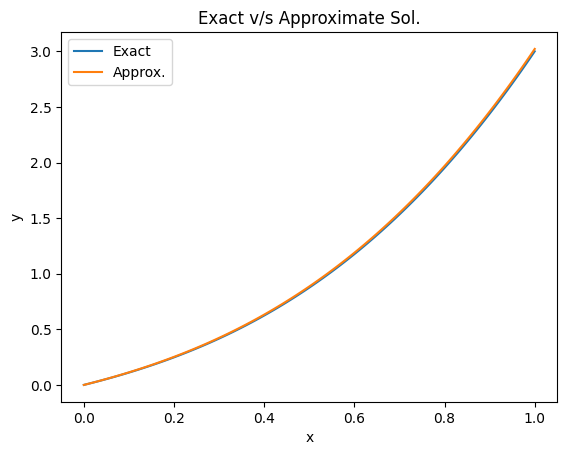

In [24]:
#plotting exact & approximate solution
plt.plot(x, y_exact_sol, label='Exact')
plt.plot(x, y_approx, label='Approx.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact v/s Approximate Sol.')
plt.legend()
plt.show()


## Plotting time required to get approx solution using and without using parallel computing v/s change in step size or number of points


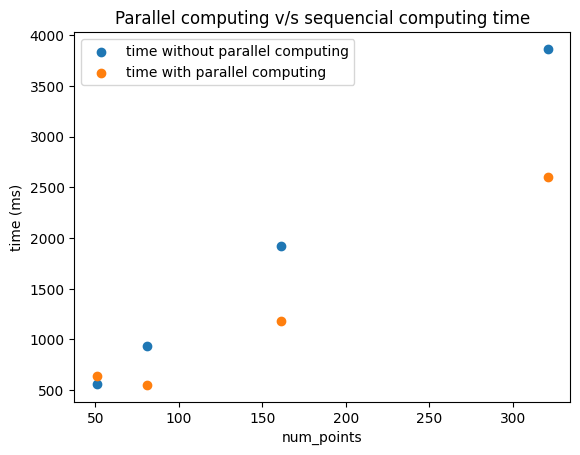

In [73]:
h_arr = [0.02, 0.0125, 0.00625, 0.003125]
t_parallel = [0]*4
t = [0]*4
N_arr = [int(1/h_arr[i]) + 1 for i in range(4)]

for i in range(4):
  start = time.time()
  y_approx = solve_bvp(h_arr[i], 0.06)
  end = time.time()
  t[i] = (end - start)*1000
  start = time.time()
  y_approx = solve_bvp_parallel(h_arr[i], 0.06)
  end = time.time()
  t_parallel[i] = (end - start)*1000


plt.scatter(N_arr, t, label='time without parallel computing')
plt.scatter(N_arr, t_parallel, label='time with parallel computing')
plt.xlabel('num_points')
plt.ylabel('time (ms)')
plt.title('Parallel computing v/s sequencial computing time')
plt.legend()
plt.show()



## Plotting time required to get approx solution using and without using parallel computing v/s change in error tolerance


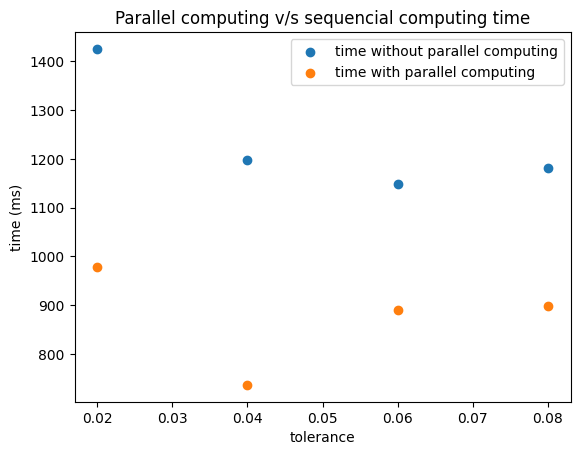

In [76]:
tol = [0.08, 0.06, 0.04, 0.02]
t_parallel = [0]*4
t = [0]*4

for i in range(4):
  start = time.time()
  y_approx = solve_bvp(0.01, tol[i])
  end = time.time()
  t[i] = (end - start)*1000
  start = time.time()
  y_approx = solve_bvp_parallel(0.01, tol[i])
  end = time.time()
  t_parallel[i] = (end - start)*1000

plt.scatter(tol, t, label='time without parallel computing')
plt.scatter(tol, t_parallel, label='time with parallel computing')
plt.xlabel('tolerance')
plt.ylabel('time (ms)')
plt.title('Parallel computing v/s sequencial computing time')
plt.legend()
plt.show()

